In [ ]:
from skimage.transform import hough_circle, hough_circle_peaks
from skimage.feature import canny
import cv2 
import numpy as np
import pywt
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
import csv

import os
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Segmentation 
def mask (image, Fcint, Fcext, cxe, cye, cxi, cyi):
    nl= image.shape[0]
    nc=  image.shape[1]
    xe = np.arange(-cxe[0],nc-cxe[0],1)
    ye = np.arange(-cye[0],nl-cye[0],1)
    xxe, yye = np.meshgrid(xe, ye, sparse=True)
    ze = np.sqrt(xxe*xxe + yye*yye)
    xi = np.arange(-cxi[0],nc-cxi[0],1)
    yi = np.arange(-cyi[0],nl-cyi[0],1)
    xxi, yyi = np.meshgrid(xi, yi, sparse=True)
    zi = np.sqrt(xxi*xxi + yyi*yyi)
    
    return (ze<Fcext)*(Fcint<zi)

def seg (image) :   
# Thresholding and edge detection
    ret1,th1 = cv2.threshold(image,35,255,cv2.THRESH_BINARY)
    edgesint= canny(th1, sigma=3, low_threshold=150, high_threshold=255)

    ret2,th2 = cv2.threshold(image,100,255,cv2.THRESH_BINARY)
    edgesext = canny(th2, sigma=3, low_threshold=150, high_threshold=255)

# calculate hough radius
    hough_radiii = np.arange(10, 2000)
    hough_resi = hough_circle(edgesint, hough_radiii)

    hough_radiie = np.arange(50, 2000)
    hough_rese = hough_circle(edgesext, hough_radiie)

# Select the most prominent 2 circles
    accumsi, cxi, cyi, radiii = hough_circle_peaks(hough_resi, hough_radiii,total_num_peaks=1)
    accumse, cxe, cye, radiie = hough_circle_peaks(hough_rese, hough_radiie,total_num_peaks=1)
    
    if ( len(cxi)!= 0 ) and (len(cxe)!= 0) and ( len(cyi)!= 0 ) and (len(cye)!= 0) and (radiii[0]!= 0) and (radiie[0]!= 0) :
        Seg = (image) * mask (image, radiii, radiie, cxe, cye, cxi, cyi)
        return Seg, cxi[0],cyi[0], radiii[0], radiie[0]
    
    else : return [], None, None,None, None

In [ ]:
# Reflections 
def reflect(gray):
    # reflections' localizing and enhancement  
    ret1,th1 = cv2.threshold(gray,200,255,cv2.THRESH_BINARY)
    refpart = gray*(th1//255)
    refpart  = refpart.astype('uint8')
    ref_HE= cv2.equalizeHist(refpart)
    
    # image totally enhaced 
    img_enh_f = gray - th1 + ref_HE

    for i in range(img_enh_f.shape[0]):
      for j in range(img_enh_f.shape[1]):
        img_enh_f[i][j]= max(0,img_enh_f[i][j])  # didnt find relu function in openCV


    return img_enh_f 

In [ ]:
# Normalisation
def norm (image, cxi,cyi, radiii, radiie):
    if (cxi != None) & (cyi != None) & (radiii != None) & (radiie != None):
      theta = np.arange(0, 360, 1) #theta
      rad = np.arange(0, (radiie-radiii), 1) #radius
      
      normal = np.empty(shape = [rad.size, theta.size])
      
      for t in theta:
          for r in rad:
              polarX = int(((r+radiii) * np.cos(t*3.14/180)) + cxi)
              polarY = int(((r+radiii) * np.sin(t*3.14/180)) + cyi)
              if (polarX < image.shape[1]) and (polarY < image.shape[0]):
                  normal[int(r)][int(t) - 1] = image[polarY][polarX]
              else : 
                  normal[int(r)][int(t) - 1] = 0
              # normal = normal.astype('uint8')
      return normal
    else : return []

In [ ]:
# Enhacement
def gammaCorrection(img, gamma):
    table = np.array([((i / 255) ** (gamma)) * 255 for i in range(256)])
    return cv2.LUT(img, table)

def gamma (grayimg):     
    hist, bins = np.histogram(grayimg , bins= np.arange(0,256)) 
    if(len(hist)!=len(bins)):
        hist = np.append(hist, 0 )
    index = np.where(hist == max(hist))[0][0]
    if (index>160):
        return 0.9
    else :
        if (index < 60): 
            return 1.1
        else : return 1   
    
def enh(gray) :
    # enhacement of the image
    gray = gray.astype(np.uint8)
    hist = cv2.equalizeHist(gray)
    med= cv2.medianBlur(hist,3)
    GIC = gammaCorrection(med,gamma(gray))
    filterSize =(3, 3)
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, filterSize)  
    img1 = gray - cv2.morphologyEx(GIC, cv2.MORPH_BLACKHAT,kernel) - cv2.morphologyEx(GIC, cv2.MORPH_TOPHAT,kernel) 
    return img1

In [ ]:
# Preprocessing 
def prepro (image):
    segm,cxi,cyi, radiii, radiie = seg(image)
    
    if len(segm) != 0 :
        ref = reflect(segm)
        normal = norm(ref,cxi,cyi, radiii, radiie)
        if (normal.shape[0]>0):
          enhc = enh(normal)
        return enhc
    else : 
        return segm

In [ ]:
# creating dataset
labels=[]
label_id={}

x=[]
y=[]

newpath = '/content/drive/MyDrive/PFE/casiaseg'
with open('/content/drive/MyDrive/PFE/casiaseg.csv', 'w', newline='') as file:
    writer = csv.writer(file)
    for root, dir, images in os.walk('/content/drive/MyDrive/PFE/casiamodif'):
        for img in images:
            if img.endswith('jpg') :
                path= os.path.join(root, img)
                label = img[0:5]
                    
                if not (label in labels) :
                    labels.append(label)
                    label_id [label] = len(labels)

                imag = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
                imag = prepro(imag)

                if len(imag) != 0 :
                  cv2.imwrite(f'{newpath}/{img}', imag)
                  writer.writerow([path, label_id [label]]) 

             # LL  = pywt.dwt2(img, 'bior2.2' )[0]

                # x.append(LL)
#                 y.append(label_id[label])
# # x= np.array(x)
# y= np.array(y)


In [ ]:
y.shape

(32044,)

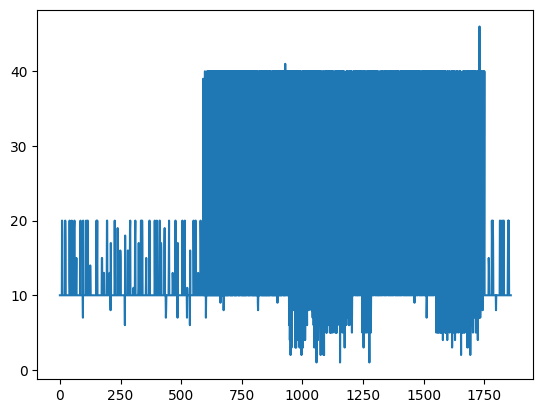

In [ ]:
from skimage import exposure
import matplotlib.pyplot as plt

hist = exposure.histogram(y)
plt.plot(hist[0])

In [ ]:
# Dividing the data set into train and test and training the model
xtr, xts, ytr, yts = train_test_split(x,y, test_size=0.2)
model = SVC(kernel='linear')
model.fit(xtr, ytr)

AttributeError: ignored